# Other

**Goal:** Bla

This notebook is divided in 2 parts:

* **1. Bla**

***

In [4]:
%run ../setup_environment.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [274]:
# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)

# create the is_artefact class
impact['is_artefact'] = impact.confidence_class == 'UNLIKELY'
display(get_table(impact.is_artefact))

# create the is_driver class
impact['is_driver'] = False
impact.loc[impact.oncogenic.isin(['Likely Oncogenic', 'Predicted Oncogenic', 'Oncogenic']), 'is_driver'] = True
display(get_table(impact.is_driver))

,count_,freq_
False,187012,96.3%
True,7199,3.7%


,count_,freq_
False,129238,66.5%
True,64973,33.5%


## Hotspots artefact

In [257]:
aggregation = {
    'mut_key': {'number': 'count'},
    'VEP_SYMBOL': {'x': lambda x: x.iloc[0]},
    'VEP_gnomAD_total_AF_max': {'x': lambda x: x.iloc[0],
                                'str': lambda x: '%.2f' % (x.iloc[0] * 100) + '%'}
}

dd = impact[impact.is_artefact].groupby('mut_key').aggregate(aggregation)
dd.head()

/Users/guilminp/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


mut_key VEP_SYMBOL VEP_gnomAD_total_AF_max       
                    number          x                       x    str
mut_key                                                             
10_104263959_C_T         1       SUFU                0.000531  0.05%
10_104263974_C_-         1       SUFU                0.000000  0.00%
10_104309726_G_T         1       SUFU                0.000000  0.00%
10_114711033_GT_CA       1     TCF7L2                0.000000  0.00%
10_114900968_A_T         1     TCF7L2                0.000000  0.00%

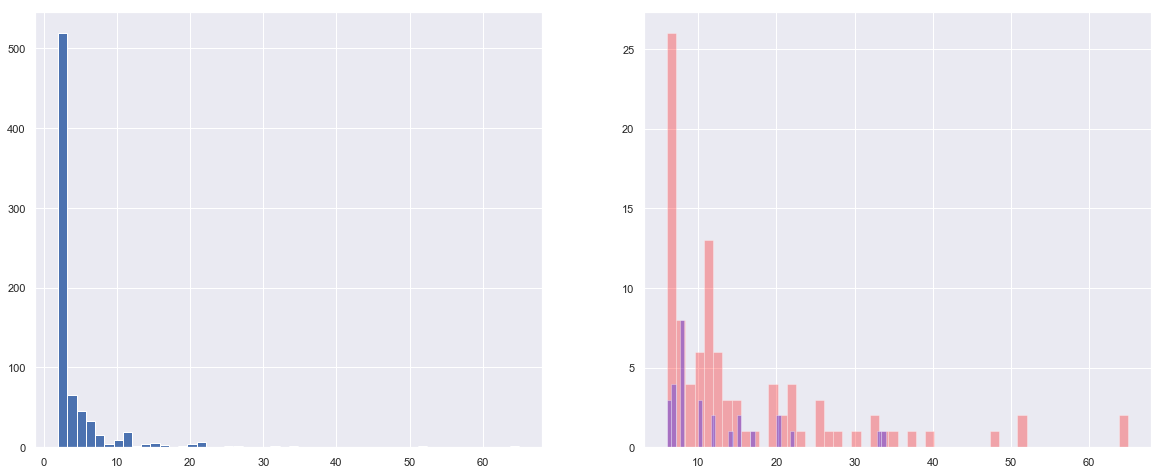

In [189]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))
ax0.hist(dd[dd.mut_key.number > 1].mut_key.number, bins=50);
# 0.01%
ax1.hist(dd[(dd.mut_key.number > 5) & (dd.VEP_gnomAD_total_AF_max.x >= 0.0001)].mut_key.number, bins=50, alpha = 0.3, color='red');
ax1.hist(dd[(dd.mut_key.number > 5) & (dd.VEP_gnomAD_total_AF_max.x < 0.0001)].mut_key.number, bins=50, alpha = 0.3, color='blue');

In [261]:
get_table(dd.mut_key.number).head()

,count_,freq_
1,3655,82.8%
2,401,9.1%
3,118,2.7%
4,66,1.5%
5,45,1.0%


In [150]:
get_table(dd.VEP_SYMBOL.x).head()

,count_,freq_
TP53,139,3.1%
ARID1A,95,2.2%
APC,78,1.8%
KMT2C,66,1.5%
ZFHX3,62,1.4%


In [191]:
dd.sort_values(('mut_key', 'number'), ascending=False).head(10)

mut_key VEP_SYMBOL VEP_gnomAD_total_AF_max        
                         number          x                       x     str
mut_key                                                                   
6_29910549_G_A               65      HLA-A                0.000359   0.04%
7_128829040_GCT_-            64        SMO                0.001050   0.11%
9_101867538_GGCGGCGGC_-      52     TGFBR1                0.096264   9.63%
3_49722761_C_A               52       MST1                0.066230   6.62%
X_66765161_A_T               48         AR                0.000591   0.06%
6_31324509_T_A               40      HLA-B                0.105439  10.54%
6_31324496_G_T               37      HLA-B                0.003171   0.32%
13_21562482_-_GGGGCG         35      LATS2                0.425597  42.56%
7_55242478_G_C               34       EGFR                0.000000   0.00%
5_236678_G_A                 34       SDHA                0.001161   0.12%

## Hotspot real

In [239]:
aggregation = {
    'mut_key': {'number': 'count', 'more_than_one': lambda x: x.count() > 1},
    'VEP_SYMBOL': {'x': lambda x: x.iloc[0]}
}

dd = impact[~impact.is_artefact].groupby('mut_key').aggregate(aggregation)
dd.head(10)

/Users/guilminp/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


mut_key               VEP_SYMBOL
                                  number more_than_one          x
mut_key                                                          
10_104263912_G_A                       1         False       SUFU
10_104263932_GCGCCCCCGGCCCCACC_-       2          True       SUFU
10_104263935_C_-                       1         False       SUFU
10_104263935_C_T                       1         False       SUFU
10_104263941_G_A                       3          True       SUFU
10_104263952_C_-                       1         False       SUFU
10_104263973_-_C                      12          True       SUFU
10_104263974_C_-                       2          True       SUFU
10_104263979_C_A                       1         False       SUFU
10_104263992_C_T                       1         False       SUFU

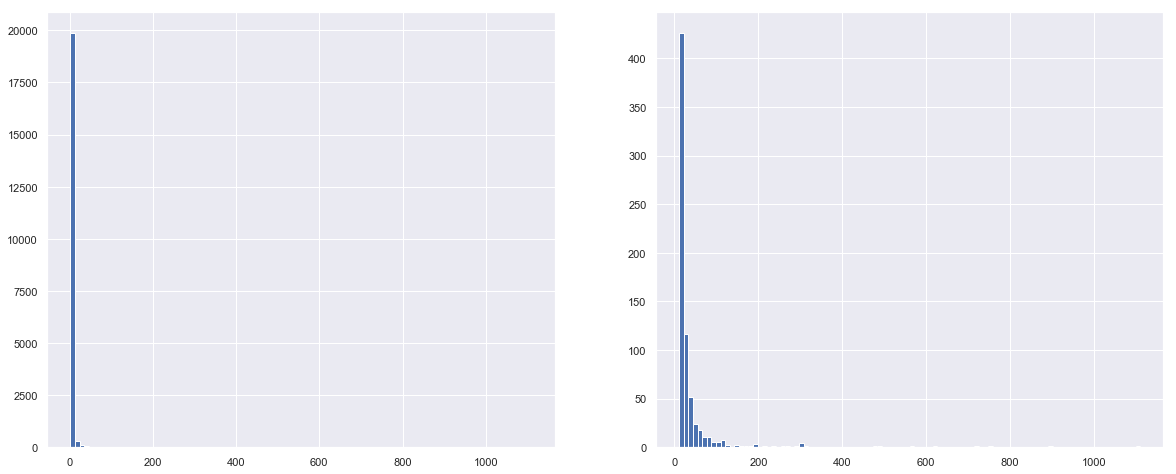

In [199]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))
ax0.hist(dd[dd.mut_key.number > 1].mut_key.number, bins=100);
ax1.hist(dd[dd.mut_key.number > 10].mut_key.number, bins=100);

## Impact without hotspots

In [248]:
aggregation = {
    'mut_key': {'number': 'count',
                'more_than_one': lambda x: x.count() > 1},
    
    'sample_mut_key': {'list': lambda x: x.values.tolist(),
                       'selected': lambda x: x.sample(1, random_state=42)}
}

dd = impact.groupby('mut_key').aggregate(aggregation)
dd.head(10)

/Users/guilminp/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


mut_key                \
                                  number more_than_one   
mut_key                                                  
10_104263912_G_A                       1         False   
10_104263932_GCGCCCCCGGCCCCACC_-       2          True   
10_104263935_C_-                       1         False   
10_104263935_C_T                       1         False   
10_104263941_G_A                       3          True   
10_104263952_C_-                       1         False   
10_104263959_C_T                       1         False   
10_104263973_-_C                      12          True   
10_104263974_C_-                       3          True   
10_104263979_C_A                       1         False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sample_mut_key  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                              list   
mut_key                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
10_104263912_G_A                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0004423-T01-IM5_10_104263912_G_A]   
10_104263932_GCGCCCCCGGCCCCACC_-                                                                                                                                                                                                                                                                                                                                          [P-0001027-T01-IM3_10_104263932_GCGCCCCCGGCCCCACC_-, P-0015687-T01-IM6_10_104263932_GCGCCCCCGGCCCCACC_-]   
10_104263935_C_-                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0015938-T01-IM6_10_104263935_C_-]   
10_104263935_C_T                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0012445-T01-IM5_10_104263

In [255]:
impact_unified = impact[impact.sample_mut_key.isin(dd.sample_mut_key.selected)]
print(impact_unified.shape)
get_table(impact_unified.is_artefact)

(132275, 64)


,count_,freq_
False,128345,97.0%
True,3930,3.0%


## Get inconsistent artefacts

In [291]:
get_table(impact[impact.is_artefact].is_driver)

,count_,freq_
False,5909,82.1%
True,1290,17.9%


In [292]:
somatic_mut_keys = impact[~impact.is_artefact].mut_key.values
impact['as_somatic'] = impact.mut_key.isin(somatic_mut_keys)
get_table(impact[impact.is_artefact].as_somatic)

,count_,freq_
False,4845,67.3%
True,2354,32.7%


In [293]:
impact['is_inconsistent'] = impact.as_somatic | impact.is_driver
get_table(impact[impact.is_artefact].is_inconsistent)

,count_,freq_
False,4115,57.2%
True,3084,42.8%
